# Exploration et filtre des données

L'objectif de ce notebook est de trouver les décisions qui correspondent à ce que l'on cherche. 

A savoir : des décisions qui concernent un recours par une entreprise ou un particulier contre une majoration de ses impôts.

Plusieurs types de majorations peuvent exister :

- 40% : manquement délibéré (mauvaise foi du contribuable)
- 80% : abus de droit (tu fais un montage pour payer moins d’impôt)
- 100% : opposition à contrôle fiscal


## 0. Installation et import des librairies

In [7]:
!pip install -q tqdm

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
import os

## 1. Lecture d'un fichier test pour comprendre son agencement

Par exemple, le fichier n° 19LY01259, qui concerne une décharge du contribuable.

In [5]:
# lecture du csv qui contient les données analysées dans le notebook 1
df = pd.read_csv("../data/intermediate_data.csv")

C:\Users\basil\AppData\Local\Temp\ipykernel_5160\3663729244.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/intermediate_data.csv")


In [3]:
# on récupère le chemin du fichier désiré
path = df[df.id == "21MA02603"]["path"].values[0]

# on ouvre le fichier avec Visual Studio Code
os.system(f"code {path}")

0

## 2. Filtre des décisions


On cherche des mots clés pour discriminer les différentes majorations en étant les plus prudents possibles (on ne veut garder que les bones décisions, au risque d'en rater quelques unes).

In [ ]:
mots_cles_40 = ["manquement délibéré"]

mots_cles_80 = ["abus de droit"]

mots_cles_100 = ["opposition à contrôle fiscal"]


# fonction pour trouver les mots clés dans un texte
def find_mots_cles(text, mots_cles):
    # pour tous les mots clés cherchés
    for mot in mots_cles:
        # si on trouve un mot clé
        if re.search(mot, text):
            # on retourne True
            return True
    # si on ne trouve aucun mot clé, on retourne False
    return False


# fonction pour trouver à quelle majoration correspond un texte
def discriminate_majoration(text):
    # si c'est une majoration de 40%
    if find_mots_cles(text, mots_cles_40):
        return "40%"
    # si c'est une majoration de 80%
    elif find_mots_cles(text, mots_cles_80):
        return "80%"
    # si c'est une majoration de 100%
    elif find_mots_cles(text, mots_cles_100):
        return "100%"
    # sinon, on ne sait pas
    else:
        return "other"


# fonction pour lire un fichier et discriminer la majoration
def read_and_discriminate_majoration(path):
    # on ouvre le fichier
    with open(path, "r") as file:
        # on lit le texte
        try :
            text = file.read()
        except:
            return "error"
    # on discrimine la majoration avec la fonction précédente
    return    discriminate_majoration(text)
   
# barre de progression pour voir où on en est
tqdm.pandas()

# application de la fonction à tous les fichiers    
df["majoration"] = df.path.progress_apply(read_and_discriminate_majoration)

# sauvegarde du dataframe pour garder les données
df.to_csv("../data/intermediate_data.csv", index=False)

## 3. Quelques vérifications aléatoires

Pour vérifier que nos règles fonctionnent bien, on va ouvrir des fichiers et vérifier qu'ils sont bien categorisés.

In [9]:
# on prend un fichier catégorisé comme ayant une majoration
index = df[df.majoration != "other"].sample(1).index[0]

# on récupère le chemin du fichier
path = df.loc[index, "path"]

# on récupère la majoration qui a été attribuée
majoration = df.loc[index, "majoration"]

# on l'ouvre avec Visual Studio Code
os.system(f"code {path}")

# on affiche la majoration
print(majoration)

40%


Ces tests aléatoires semblent confirmer le bon fonctionnement de notre méthode.

## 4. Graphique : quels sont les résultats ?

Avec ces premières règles on a un corpus de **2300 décisions**. 

De manière assez prévisible, plus la sanction est importante, moins il y a de cas.

NB : 
- on a laissé les chiffres visibles pour pouvoir faire des graphiques propres
- on ne prend que les décisions pas les ordonnances de renvoi

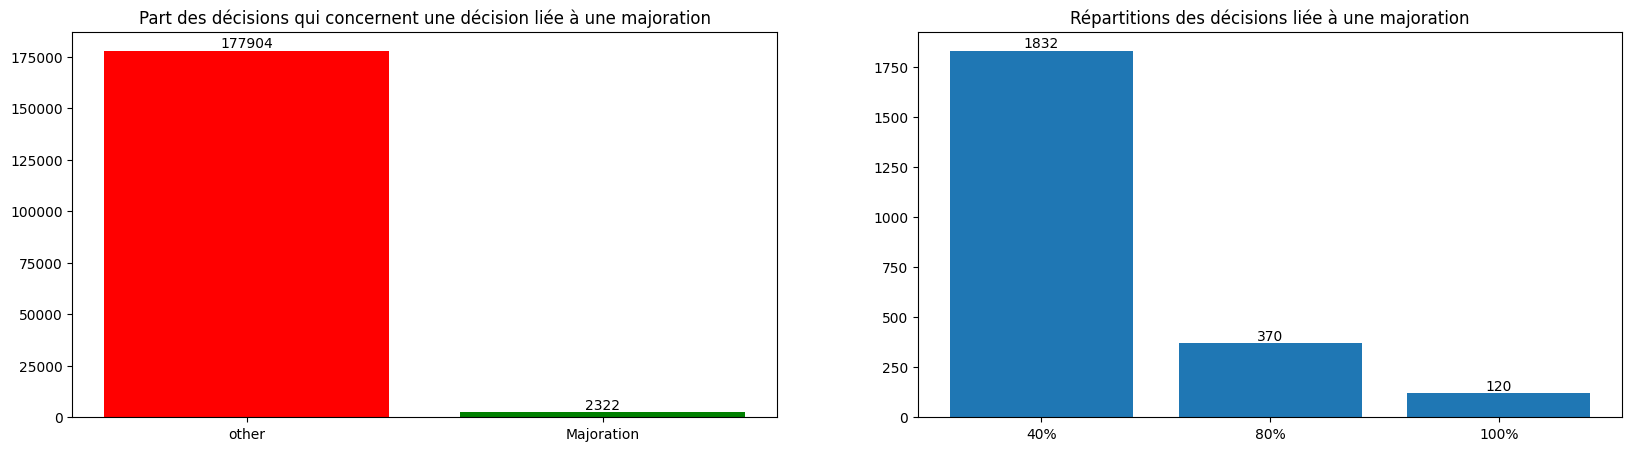

In [11]:
# remove ordonnances de renvoie
df = df[df.ordonnance_de_renvoi == False]

plot, axs = plt.subplots(1, 2, figsize=(20, 5))

# plot 1 : other vs Majoration
nb_1 = df[df.majoration == "other"].shape[0]
nb_2 = df[df.majoration != "other"].shape[0]

axs[0].bar(["other", "Majoration"], [nb_1, nb_2], color=["red", "green"])
axs[0].set_title(
    "Part des décisions qui concernent une décision liée à une majoration"
)

# plot 2 : 40% vs 80% vs 100%
nb_40 = df[df.majoration == "40%"].shape[0]
nb_80 = df[df.majoration == "80%"].shape[0]
nb_100 = df[df.majoration == "100%"].shape[0]

axs[1].bar(["40%", "80%", "100%"], [nb_40, nb_80, nb_100])
axs[1].set_title(
    "Répartitions des décisions liée à une majoration"
)

# set the numbers on top of the bars
for i in range(2):
    for bar in axs[i].patches:
        yval = bar.get_height()
        axs[i].text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            round(yval),
            ha="center",
            va="bottom",
        )

plt.show()

# save image
plot.savefig("../output/répartitions_des_majorations.png")